# Basic tutorial - Identifying tissue compartments in the human lymph node

In [1]:
import chrysalis as ch
import scanpy as sc
import matplotlib.pyplot as plt

To begin using `chrysalis`, we first load the human lymph node sample. After that, we proceed by removing the low quality capture spots and genes that are expressed in fewer than 10 spots. You can refer to the `scanpy` documentation for a comprehensive quality control (QC) tutorial.

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=6000)
sc.pp.filter_genes(adata, min_cells=10)

## 1. Detect spatially variable genes

First we detect spatially variable genes (SVGs): `ch.detect_svgs` calculates Moran's I for every gene that is expressed in at least 10% of the capture spots. This can be tuned by setting the `min_spots` parameter.

<div class="alert alert-info">
<b>Note!</b>

By default, either the top 1000 genes will be marked as spatially variable or if less genes are above the minimal Moran's I threshold, only those will be selected. This can also be set manually with the `min_morans` parameter.

</div>

In [3]:
ch.detect_svgs(adata, min_morans=0.05, min_spots=0.05)

Calculating SVGs: 100%|█████████████████████████████████████████████████████████████████████████████████| 13371/13371 [03:01<00:00, 73.82it/s]


The AnnData object can be saved and loaded freely at any point

```
adata.write(/your/path/chr.h5ad')
adata = sc.read_h5ad('/your/path/chr.h5ad')
```

Looking at the calculated Moran’s I values for the examined genes using `ch.plot_svgs`, we can determine if the default selection parameter was sufficient. In this case the inflection point is around 0.08.

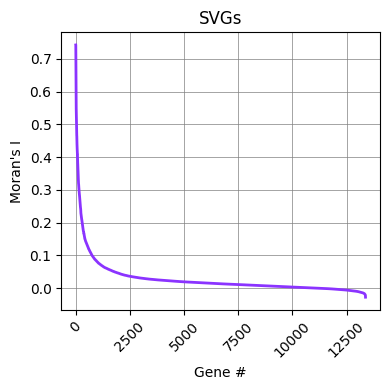

In [4]:
ch.plot_svgs(adata)
plt.show()

We can modify the number of SVGs by setting a different threshold and replacing the `spatially_variable` column with the new selection in the AnnData object.

In [5]:
moran_df = adata.var[adata.var["Moran's I"] > 0.08]
adata.var['spatially_variable'] = [True if x in moran_df.index else False for x in adata.var_names]

## 2. Dimensionality reduction

The next step is to run `ch.pca` to perform PCA (Principal Component Analysis) on the SVGs. In this step, we normalize the raw count matrix using the default normalization and log transform functions provided by `scanpy`, but alternative normalization methods can also be used.

In [6]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)

We can inspect the explained variance after the PCA.

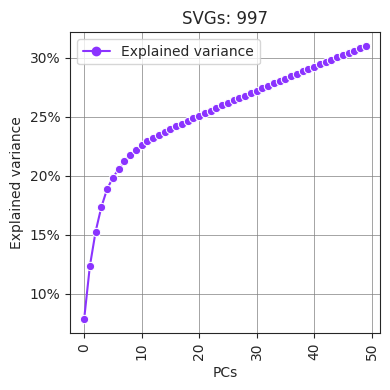

In [7]:
ch.plot_explained_variance(adata)
plt.show()

## 3. Identify tissue compartments

We call `ch.aa` to infer tissue compartments using arcetypal analysis. We can define the number of input PCs (we recommend 20 for most tissue samples) and the number of tissue compartments to be found. `ch.plot` is used to visualize the results as a composite image with randomly assigned colors to each tissue compartment.

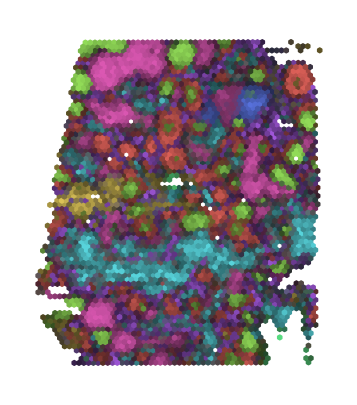

In [8]:
ch.aa(adata, n_pcs=20, n_archetypes=8)
ch.plot(adata, dim=8)
plt.show()

We can visualize the SVG signatures associated with each tissue compartment using `ch.plot_heatmap`. This heatmap allows us to compare the signatures across compartments, providing valuable insights into functional similarities or differences. Within a specific compartment, positive weights highlight genes that, when expressed, play a pivotal role in defining the identity of that compartment. Conversely, negative values represent genes that are typically absent in the expression profile of the compartment.

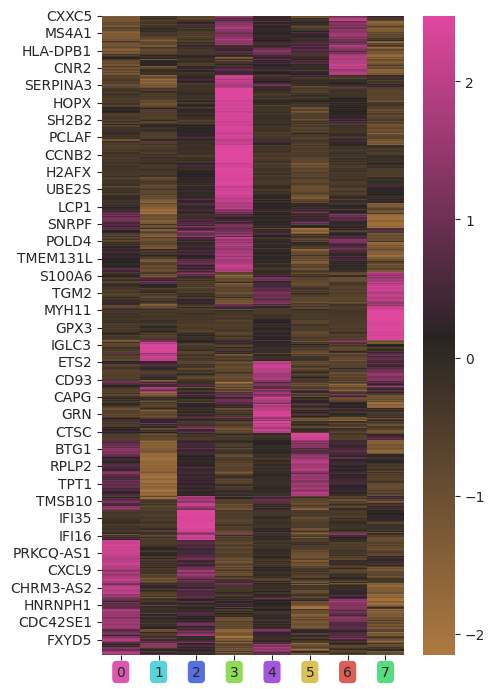

In [9]:
ch.plot_heatmap(adata, reorder_comps=True)
plt.show()

To further examine the top 20 genes associated with the compartments, we can use the `ch.plot_weights` function. As an example, we may observe canonical T cell marker genes, such as *TCF7*, and B cell marker genes, such as *IGKC*, *JCHAIN*.

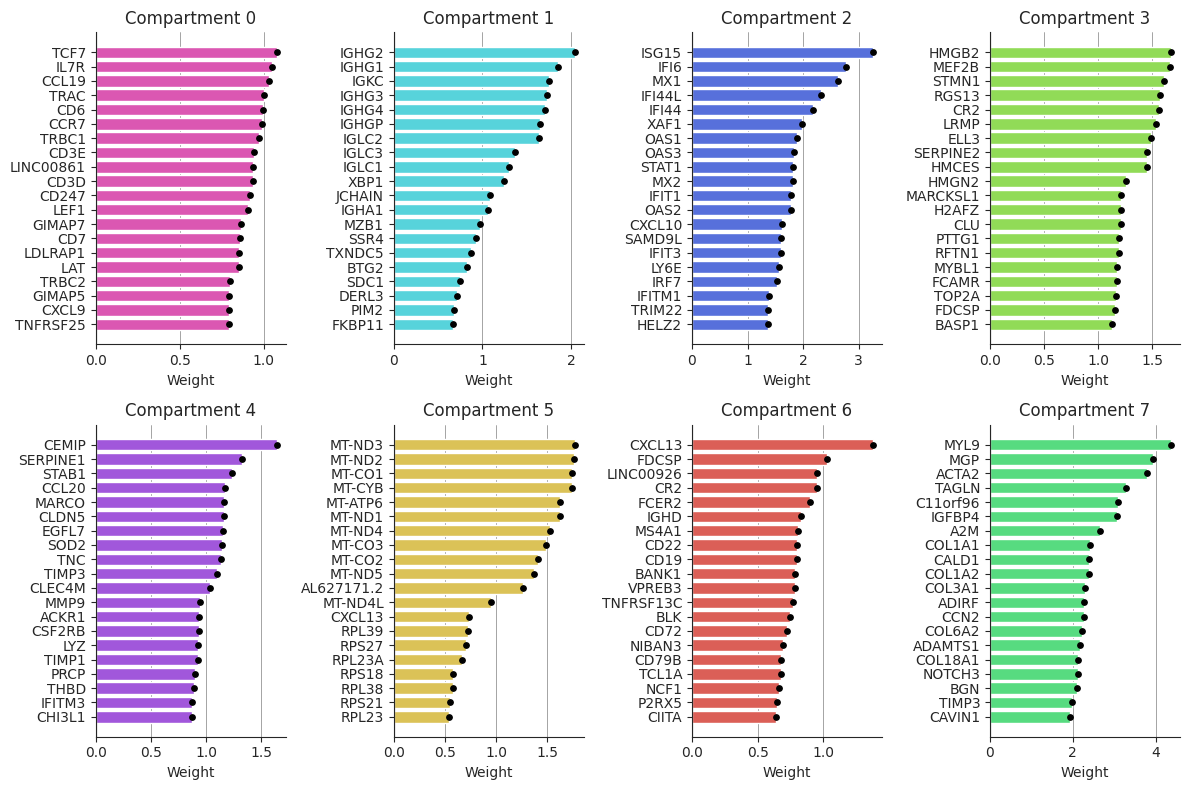

In [10]:
ch.plot_weights(adata)
plt.show()

The tissue compartments can also be visualized individually with `ch.plot_compartments`.

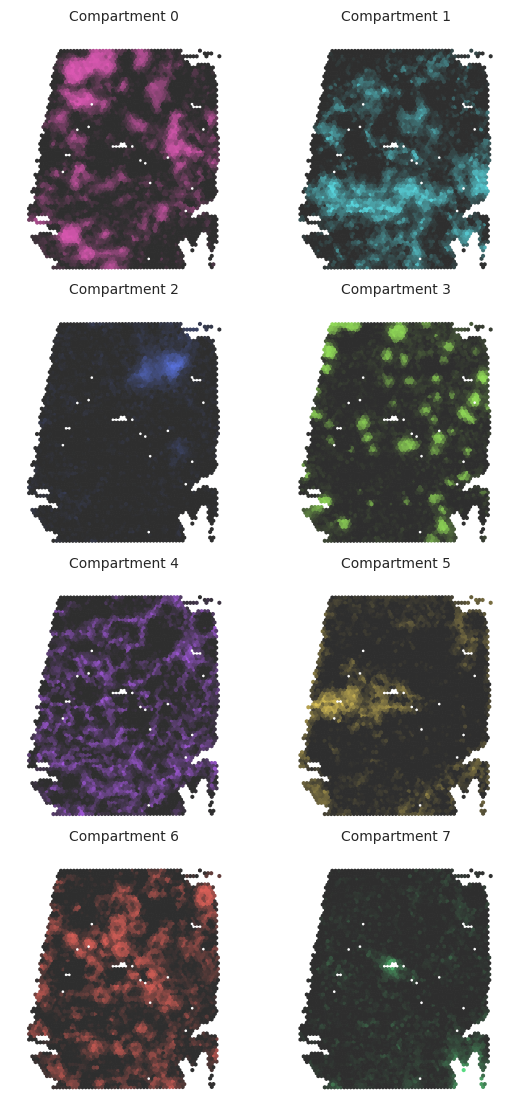

In [11]:
ch.plot_compartments(adata, ncols=4)
plt.show()

Finally, we can retrieve the weights or gene expression values as a DataFrame using `ch.get_compartment_df`, allowing further downstream analysis of the expression signatures, such as gene set enrichment, cell-cell communication, and marker gene-based cell type identification.

In [12]:
compartment_df = ch.get_compartment_df(adata)
print(compartment_df.head())

          compartment_0  compartment_1  compartment_2  compartment_3  \
ISG15         -0.103531      -0.136618       3.252953      -0.239730   
RPL22          0.295535      -0.367731       0.071478      -0.011680   
TNFRSF25       0.791888      -0.060183       0.134402      -0.312537   
TNFRSF9       -0.159019      -0.198243       0.001033       0.137416   
ENO1           0.008693      -0.332119       0.269985       0.161277   

          compartment_4  compartment_5  compartment_6  compartment_7  
ISG15         -0.030028      -0.273347      -0.181934       0.643308  
RPL22         -0.041073       0.013250       0.147203      -0.671772  
TNFRSF25      -0.121335      -0.470866      -0.232913      -0.380424  
TNFRSF9        0.407722       0.041473      -0.006960      -0.478118  
ENO1           0.056413      -0.110827      -0.021807      -0.105445  
